# Tarea 2
Autores:
- Hernán Francisco Díaz Farías
- María Angélica Parra Mendoza
- Loreto Constanza Zavala Gaete


Utilizaremos los datos que nos ha entregado una vidriería, la cual necesita que en base a la composición (química) de los vidros, determinemos cual de ellos podría venir defectuoso de fábrica. Para esto contamos con registro de 214 vidrios, para los cuales cada uno de ellos se nos entrega mediciones de cantidades de Sodio, Magnesio, Aluminio, Silicio, Potacio, Calcio, Bario y Hierro, además de un valor de tipo de vidrio.

## 1.Hacer una exploración de los datos y decidir qué modelo va a utilizar. Fundamentar su elección.
### 1.1 Cargar los datos

In [203]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, normalize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.svm import OneClassSVM
from pyod.models.dif import DIF
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import math
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [144]:
df = (
    pd.read_excel('../data/Clase 2 - Glass.xlsx')
    .drop(columns=['Unnamed: 0'])
)
df.head()

,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_of_glass,outlier
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,0


In [127]:
df.isnull().sum()

Na               0
Mg               0
Al               0
Si               0
K                0
Ca               0
Ba               0
Fe               0
Type_of_glass    0
outlier          0
dtype: int64

### 1.2 Visualización de histogramas.

De acuerdo a la descripción de las ventajas del modelo [**Isolation Forest**](https://cran.r-project.org/web/packages/isotree/vignettes/An_Introduction_to_Isolation_Forests.html), se menciona que:
- Es robusto a la presencia de valores atípicos en los datos de entrenamiento.
- Es robusto a distribuciones multimodal.
- Insensible a la escala de los datos.
- Veloz para entrenar y predecir.
- No varía a la metrica de distancia a utilizar.

Para escoger el modelo, se realizará un análisis de los histogramas de las variables para determinar si son unimodales o multimodales. Si las variables son multimodales, se utilizará el modelo **Isolation Forest**.

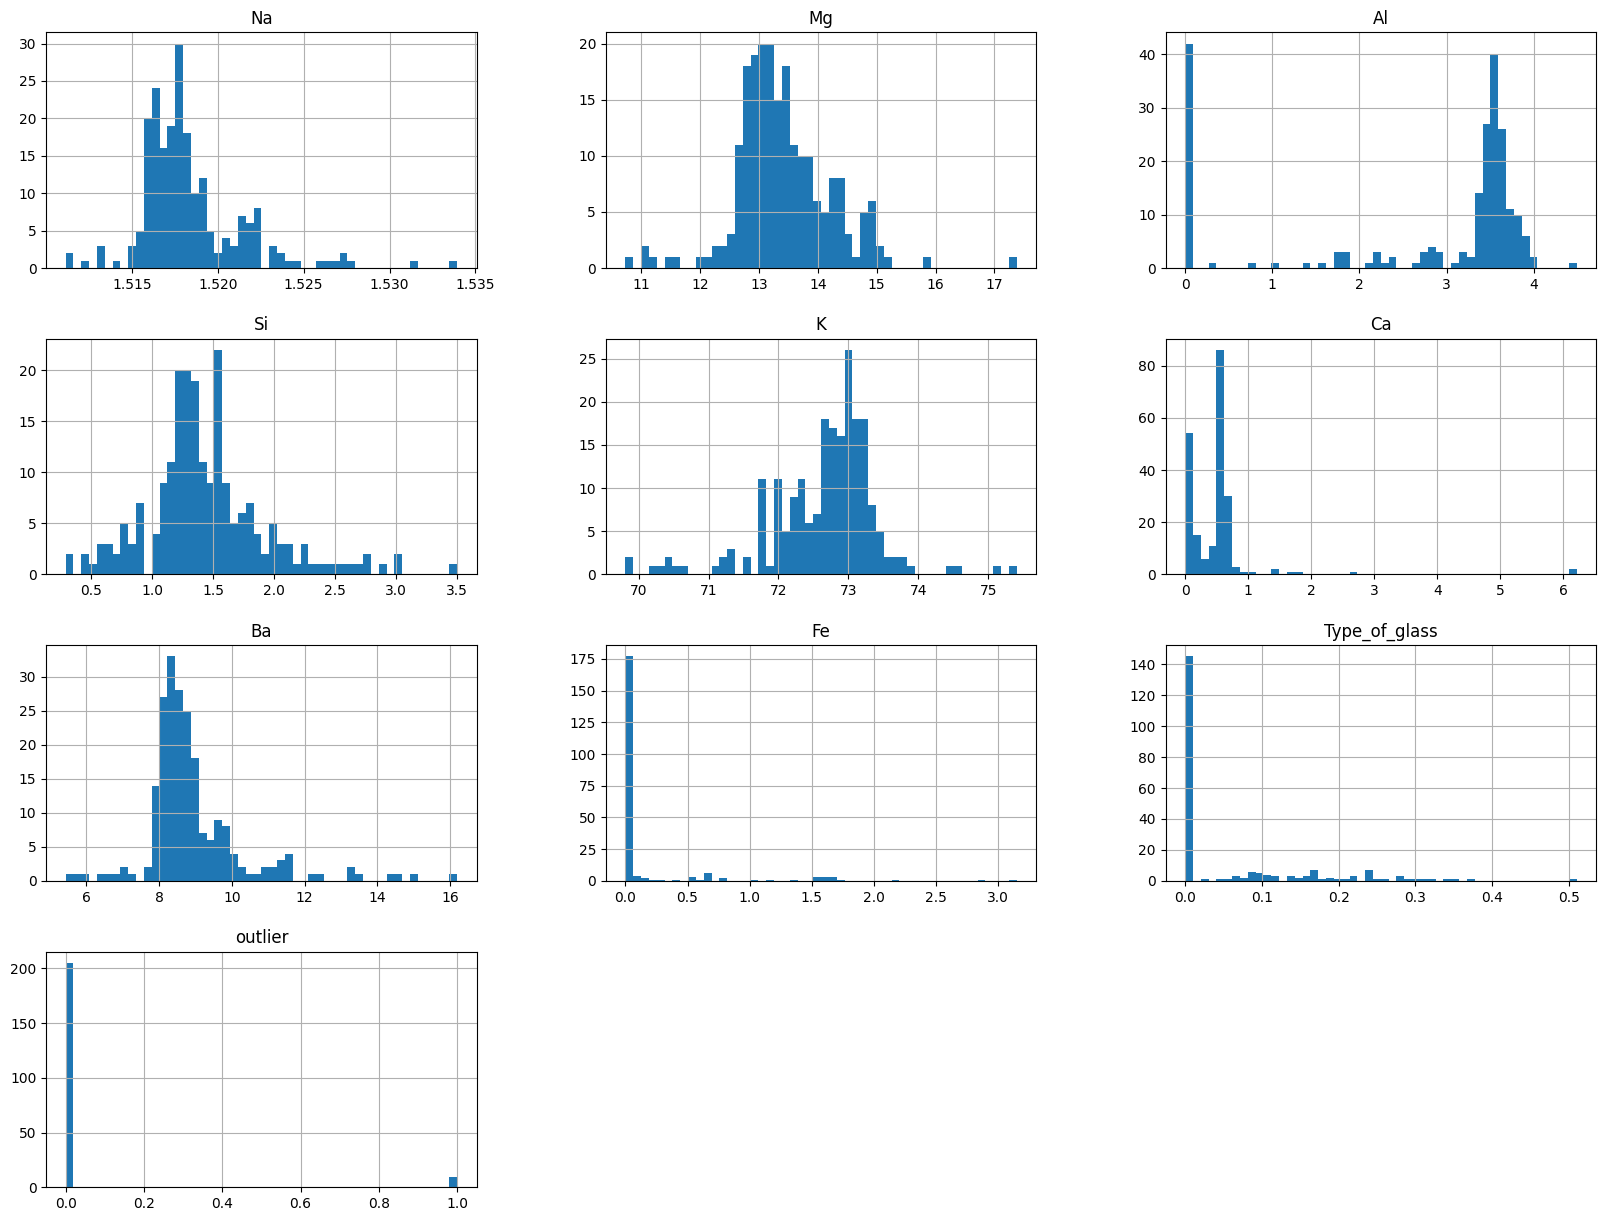

In [134]:
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

### 1.3 Scatter plot

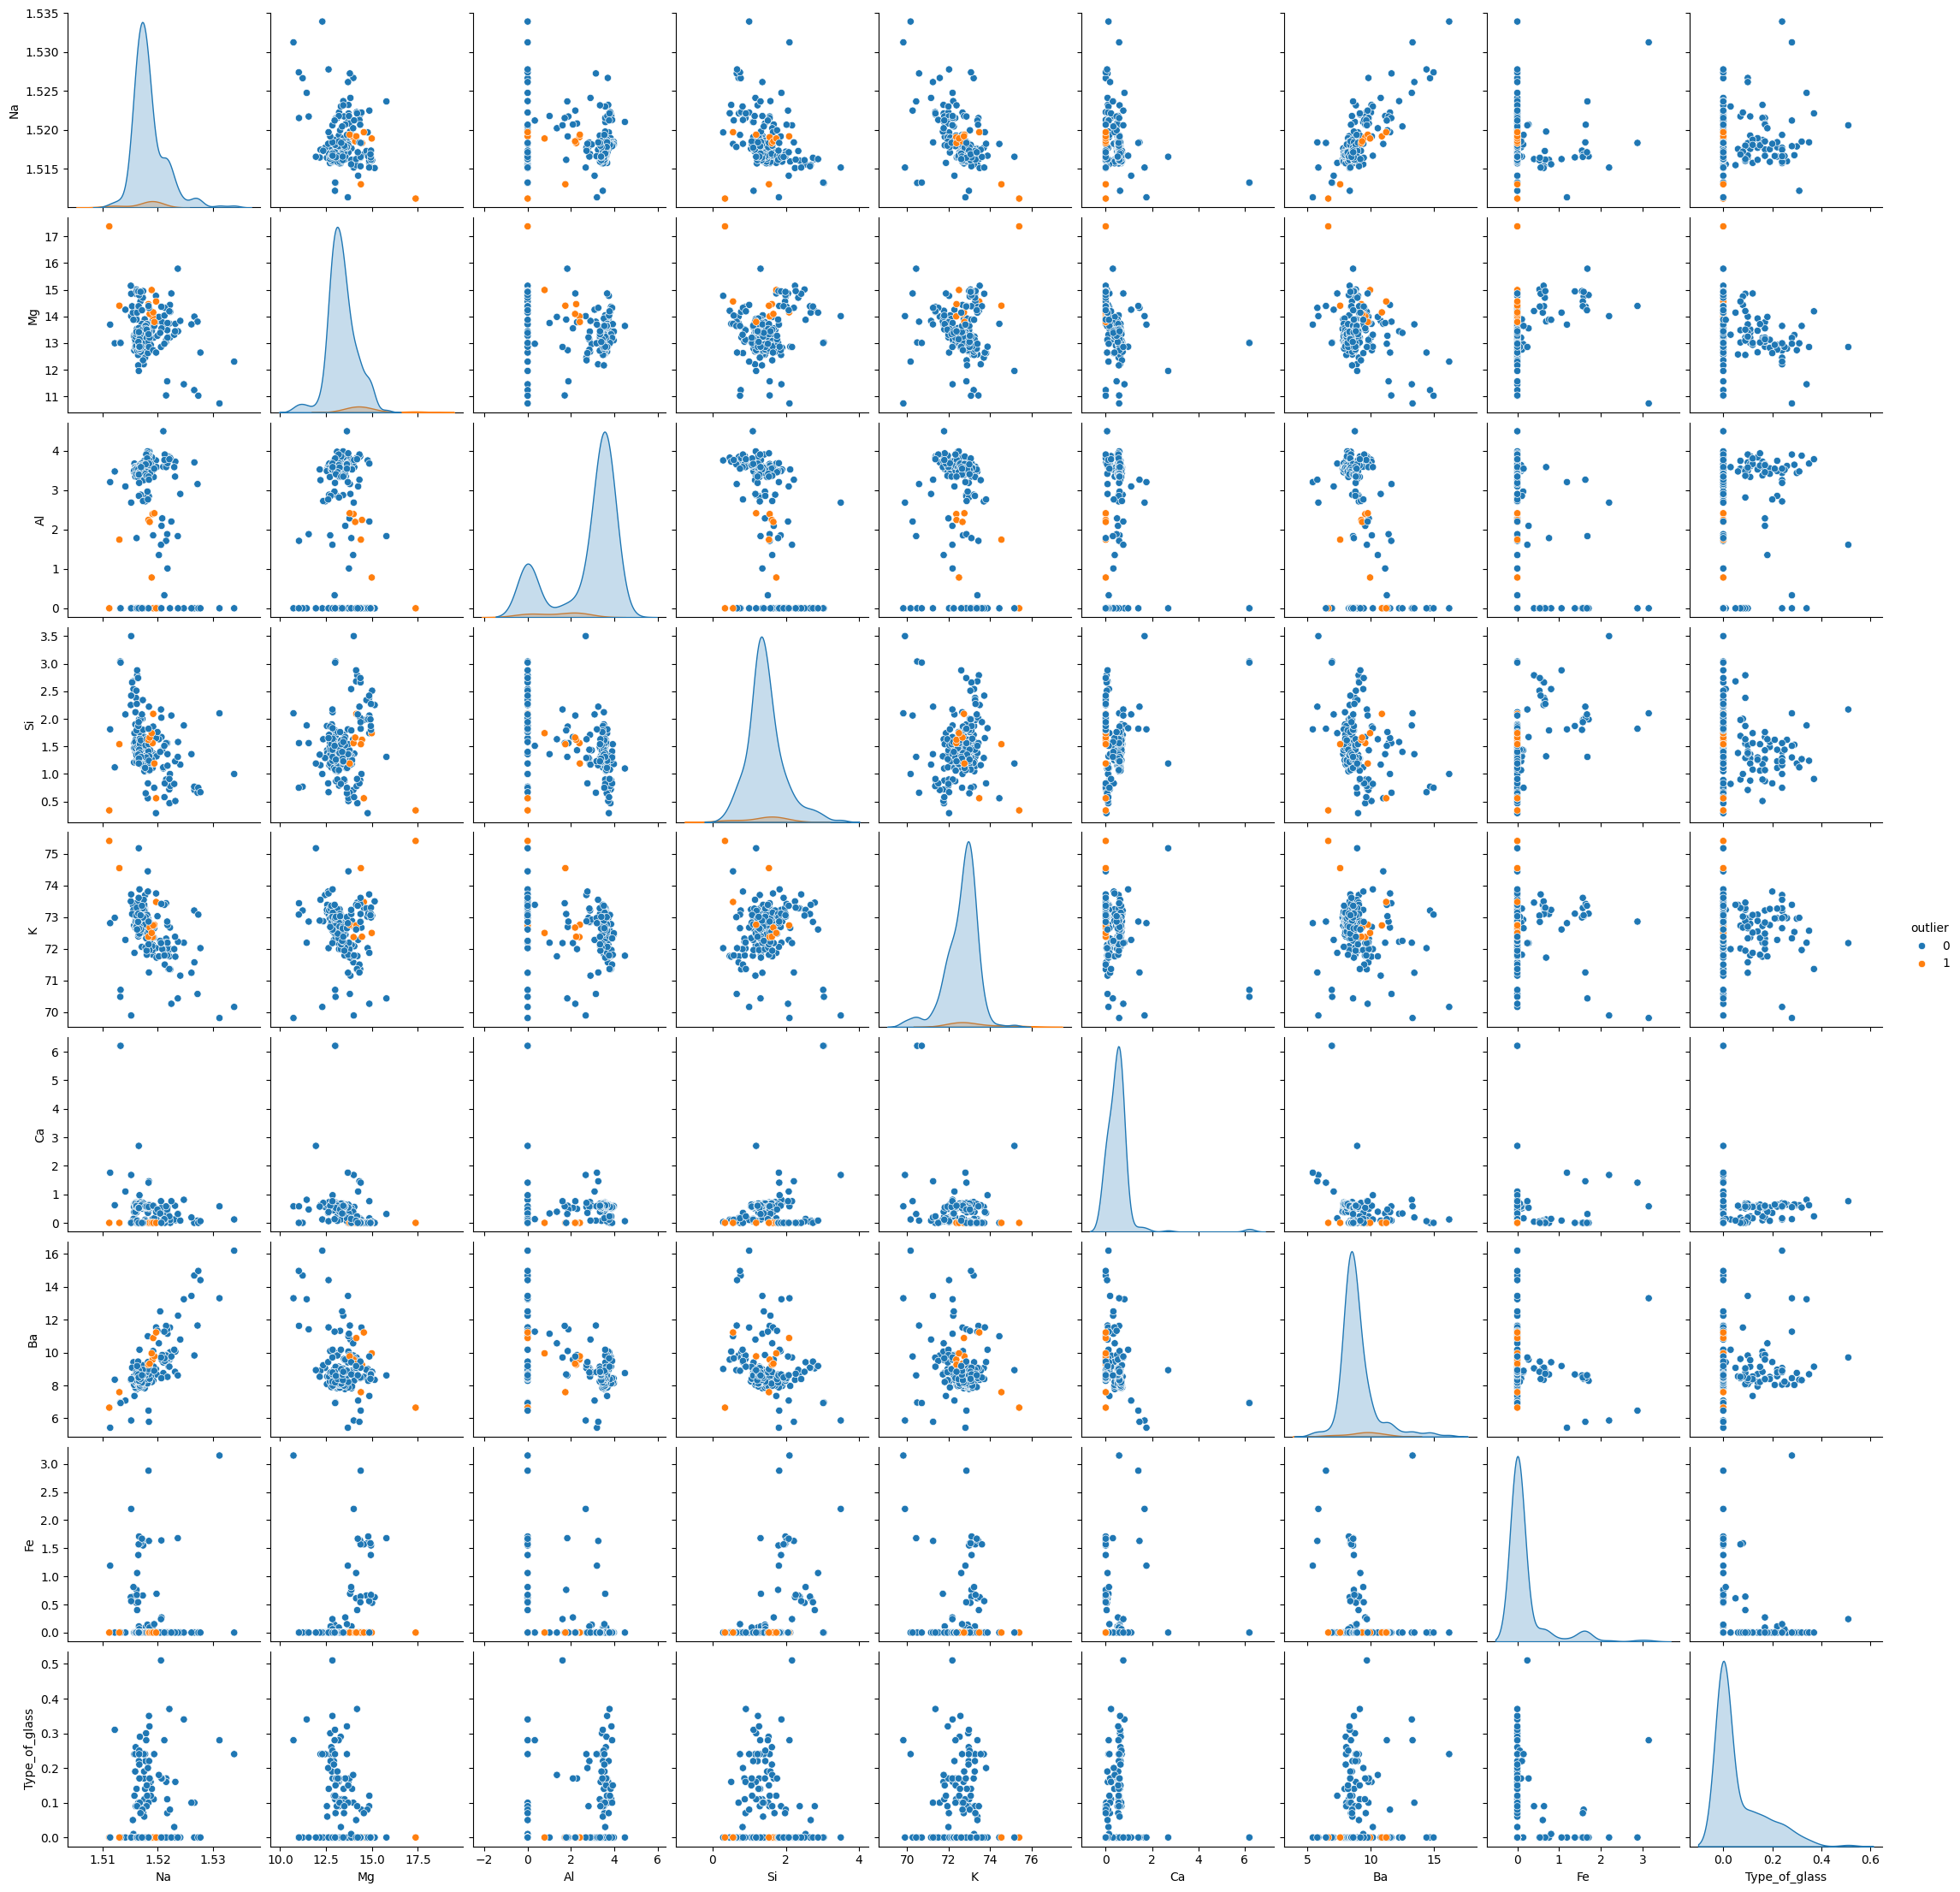

In [195]:
X = df.drop(columns=['outlier'])
y = df['outlier']
sns.pairplot(df, hue='outlier')

### 1.3 PCA

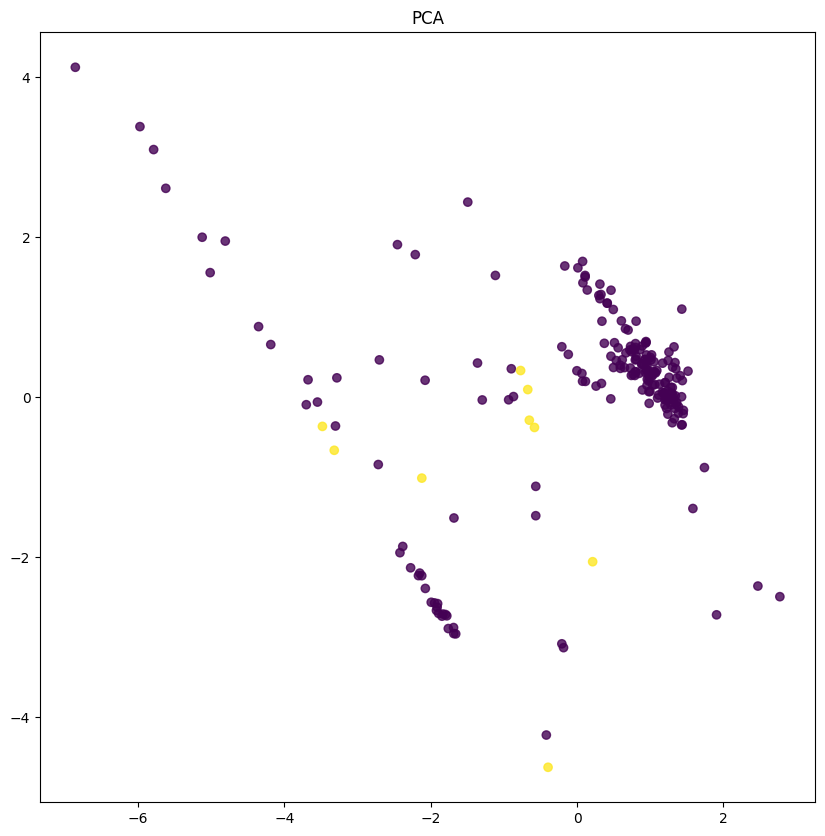

In [211]:
# X = df.drop(columns=['outlier'])
y = df['outlier']
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=0.8)
plt.title('PCA')
plt.show()


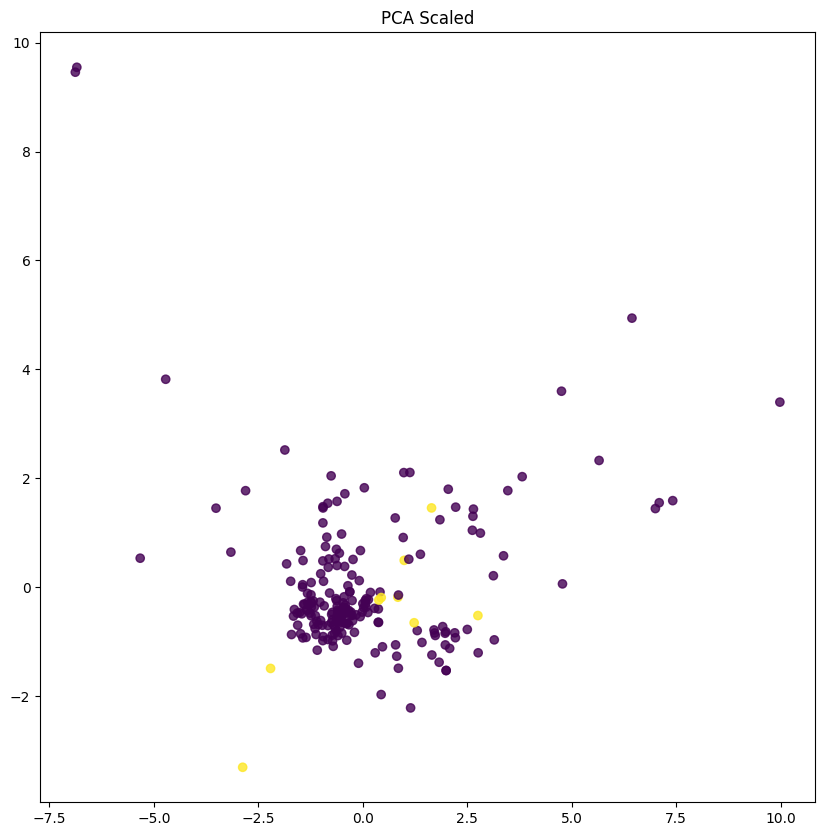

In [212]:
X_scaled = RobustScaler().fit_transform(X)
PCA_scaled = PCA(n_components=2)
X_pca_scaled = PCA_scaled.fit_transform(X_scaled)
plt.figure(figsize=(10, 10))
plt.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=y, alpha=0.8)
plt.title('PCA Scaled')
plt.show()

### Kernel trick

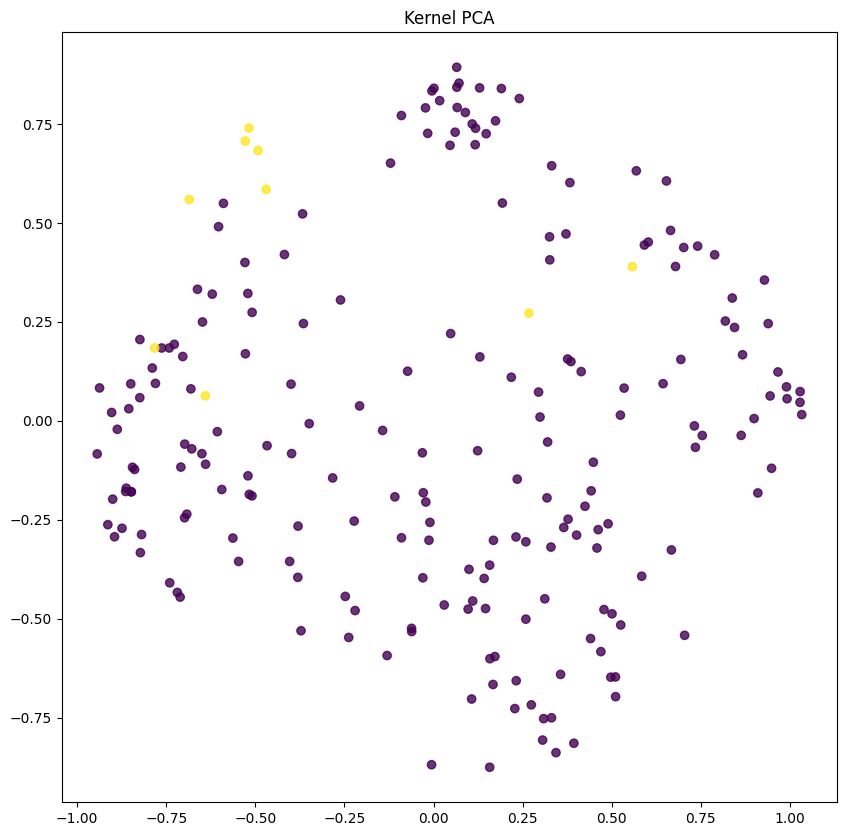

In [214]:
from sklearn.decomposition import KernelPCA
X_kpca = KernelPCA(n_components=2, kernel='cosine', n_jobs=-1).fit_transform(X_scaled)
plt.figure(figsize=(10, 10))
plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y, alpha=0.8)
plt.title('Kernel PCA')
plt.show()

In [215]:
X_kpca_df = pd.DataFrame(X_kpca, columns=['comp_0', 'comp_1'])
X_kpca_df['expanded'] = (X_kpca_df['comp_0'] ** 2) + (X_kpca_df['comp_1'] ** 2)
# graficamos con plotly en 3D
fig = px.scatter_3d(X_kpca_df, x='comp_0', y='comp_1', z='expanded', color=y)
fig.show()


In [121]:
X_kpca_df.drop(columns=['comp_0'], inplace=True)

### 1.3 Test de multimodalidad

In [7]:
for col in df.columns:
    # test dip
    dip, pval = diptest.diptest(df[col])
    if pval < 0.05:
        print(f'La variable {col} es probablemente multimodal: {dip}, {pval}')
    else:
        print(f'La variable {col} es probablemente unimodal: {dip}, {pval}')

La variable Na es probablemente unimodal: 0.027824978759555138, 0.29678227340828256
La variable Mg es probablemente unimodal: 0.02397641299510457, 0.5598736607065488
La variable Al es probablemente multimodal: 0.09813084112149532, 0.0
La variable Si es probablemente unimodal: 0.02266355140186915, 0.6621823323183281
La variable K es probablemente unimodal: 0.019910605444939947, 0.8545579937565113
La variable Ca es probablemente multimodal: 0.07971412864211103, 0.0
La variable Ba es probablemente unimodal: 0.020478284771852703, 0.8206700523552444
La variable Fe es probablemente unimodal: 0.017964693665628247, 0.9483906034584101
La variable Type_of_glass es probablemente unimodal: 0.031061022539857062, 0.15922944239922954
La variable outlier es probablemente unimodal: 0.02102803738317757, 0.7850035090854165


De acuerdo a los histogramas y el test de multimodalidad, se observa que existen variables que son unimodales y otras que son multimodales. Por lo tanto, se utilizará el modelo **Isolation Forest** para detectar los vidrios defectuosos de fábrica.

## 2. En base a su elección anterior, procese sus datos para dejarlos como input para el modelo.
### 2.1 Construcción del pipeline
Para encontrar los vidrios defectuosos de fábrica, se utilizará el modelo **Isolation Forest**. Para ello, se construirá un pipeline que permita escalar los datos y entrenar el modelo.

### 2.2 Isolation Forest

In [217]:

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', IsolationForest(random_state=2023, n_jobs=-1))
])

# Definir los hiperparámetros del modelo **Isolation Forest**:
params= {
    'model__n_estimators': [100, 200, 300],
    'model__max_samples': [50, 100, 200, 214],
    'model__contamination': [0.12, 0.13, 0.14, 0.15]
}
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_params = None
best_score = 0
best_threshold = 0

# Combinar el pipeline y los hiperparámetros
for n_estimators in params['model__n_estimators']:
    for max_samples in params['model__max_samples']:
        for contamination in params['model__contamination']:
            pipeline.set_params(
                model__n_estimators=n_estimators,
                model__max_samples=max_samples,
                model__contamination=contamination
            )
            pipeline.fit(X_kpca_df)
            scores = pipeline.decision_function(X_kpca_df)
            probas = (scores - scores.min()) / (scores.max() - scores.min())
            for umbral in threshold:
                predicciones = np.array([-1 if x > umbral else 1 for x in probas])
                # Comparar las predicciones con y
                TP = ((y == 1) & (predicciones == -1)).sum()
                TN = ((y == 0) & (predicciones == 1)).sum()
                FP = ((y == 0) & (predicciones == -1)).sum()
                FN = ((y == 1) & (predicciones == 1)).sum()
                accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
                precision = TP / (TP + FP) if (TP + FP) != 0 else 0
                recall = TP / (TP + FN) if (TP + FN) != 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
                if accuracy > best_score:
                    best_score = accuracy
                    best_params = {
                        'model__n_estimators': n_estimators,
                        'model__max_samples': max_samples,
                        'model__contamination': contamination
                    }
                    best_threshold = umbral
                    best_TP = TP
                    best_TN = TN
                    best_FP = FP
                    best_FN = FN
                    best_accuracy = accuracy
                    best_precision = precision
                    best_recall = recall
                    best_f1 = f1
print(f'Mejores hiperparámetros: {best_params} y umbral: {best_threshold}')
print(f'Mejor score: {best_score}')
print(f'TP: {best_TP}, TN: {best_TN}, FP: {best_FP}, FN: {best_FN}, Accuracy: {best_accuracy}, Precision: {best_precision}, Recall: {best_recall}, F1: {best_f1}')

Mejores hiperparámetros: {'model__n_estimators': 300, 'model__max_samples': 214, 'model__contamination': 0.12} y umbral: 0.9
Mejor score: 0.8738317757009346
TP: 0, TN: 187, FP: 18, FN: 9, Accuracy: 0.8738317757009346, Precision: 0.0, Recall: 0.0, F1: 0


In [119]:
# Usar los mejores hiperparámetros
model = IsolationForest(
    random_state=2023,
    n_jobs=-1,
    n_estimators=best_params['model__n_estimators'],
    max_samples=best_params['model__max_samples'],
    contamination=best_params['model__contamination']
)
pipeline.set_params(**best_params)
pipeline.fit(X_kpca_df)
predicciones = pipeline.predict(X_kpca_df)
# Comparar las predicciones con y
TP = ((y == 1) & (predicciones == -1)).sum()
TN = ((y == 0) & (predicciones == 1)).sum()
FP = ((y == 0) & (predicciones == -1)).sum()
FN = ((y == 1) & (predicciones == 1)).sum()
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print(f'TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}')
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}')

TP: 3, TN: 182, FP: 23, FN: 6
Accuracy: 0.8644859813084113, Precision: 0.11538461538461539, Recall: 0.3333333333333333, F1: 0.17142857142857146


In [219]:
# Definiendo las variables X e y
y = df['outlier']
X = df.drop(columns=['outlier'])


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', IsolationForest(random_state=2023, n_jobs=-1))
])

# Definir los hiperparámetros del modelo **Isolation Forest**:
params= {
    'scaler': [RobustScaler(), StandardScaler(), MinMaxScaler()],
    'model__n_estimators': [400, 500, 600],
    'model__max_samples': [50, 100, 200],
    'model__contamination': [0.13, 0.14, 0.15]
}

best_params = None
best_score = 0

# Combinar el pipeline y los hiperparámetros
for scaler in params['scaler']:
    for n_estimators in params['model__n_estimators']:
        for max_samples in params['model__max_samples']:
            for contamination in params['model__contamination']:
                pipeline.set_params(scaler=scaler,
                                    model__n_estimators=n_estimators,
                                    model__max_samples=max_samples,
                                    model__contamination=contamination)
                pipeline.fit(X)
                predicciones = pipeline.predict(X)
                # Comparar las predicciones con y
                TP = ((y == 1) & (predicciones == -1)).sum()
                TN = ((y == 0) & (predicciones == 1)).sum()
                FP = ((y == 0) & (predicciones == -1)).sum()
                FN = ((y == 1) & (predicciones == 1)).sum()
                accuracy = (TP + TN) / (TP + TN + FP + FN)
                precision = TP / (TP + FP)
                recall = TP / (TP + FN)
                f1 = 2 * (precision * recall) / (precision + recall)

                if accuracy > best_score:
                    best_score = accuracy
                    best_params = {
                        'scaler': scaler,
                        'model__n_estimators': n_estimators,
                        'model__max_samples': max_samples,
                        'model__contamination': contamination
                    }
print(f'Mejores hiperparámetros: {best_params}')
print(f'Mejor score: {best_score}')


Mejores hiperparámetros: {'scaler': RobustScaler(), 'model__n_estimators': 400, 'model__max_samples': 100, 'model__contamination': 0.13}
Mejor score: 0.8457943925233645


In [9]:
# Usar los mejores hiperparámetros
pipeline.set_params(**best_params)
pipeline.fit(X)
predicciones = pipeline.predict(X)
# Comparar las predicciones con y
TP = ((y == 1) & (predicciones == -1)).sum()
TN = ((y == 0) & (predicciones == 1)).sum()
FP = ((y == 0) & (predicciones == -1)).sum()
FN = ((y == 1) & (predicciones == 1)).sum()
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print(f'TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}')
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}')


TP: 2, TN: 179, FP: 26, FN: 7
Accuracy: 0.8457943925233645, Precision: 0.07142857142857142, Recall: 0.2222222222222222, F1: 0.10810810810810811


### 2.3 One Class SVM

In [218]:
# pipeline de SVM
pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', OneClassSVM())
])

# Definir los hiperparámetros del modelo SVM
param_grid2 = {
    'scaler': [RobustScaler(), StandardScaler(), MinMaxScaler()],
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'model__gamma': ['scale', 'auto'],
    'model__nu': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Definir la búsqueda de grilla
grid_search2 = GridSearchCV(
    pipeline2,
    param_grid2,
    cv=2,
    scoring='accuracy',
    n_jobs=-1,
)

# Hacer fit al modelo
grid_search2.fit(X, y)

# Obtener los mejores hiperparámetros
mejores_parametros2 = grid_search2.best_params_
best_score2 = grid_search2.best_score_

print(f'Mejores hiperparámetros: {mejores_parametros2}')
print(f'Mejor score: {best_score2}')


Mejores hiperparámetros: {'model__gamma': 'scale', 'model__kernel': 'linear', 'model__nu': 0.1, 'scaler': StandardScaler()}
Mejor score: 0.04205607476635514


In [10]:
# DIF
y = df['outlier']
X = df.drop(columns=['outlier'])

pipeline = Pipeline([
    ('model', DIF(random_state=2024))
])

params= {
    'model__n_estimators': [4, 5, 6],
    'model__max_samples': [100, 200, 214],
    'model__contamination': [0.13, 0.14, 0.15],
    'model__n_ensemble': [10, 11, 12]
}

best_params = None
best_score = 0

# Combinar el pipeline y los hiperparámetros
for ensemble in params['model__n_ensemble']:
    for n_estimators in params['model__n_estimators']:
        for max_samples in params['model__max_samples']:
            for contamination in params['model__contamination']:
                pipeline.set_params(
                                    model__n_estimators=n_estimators,
                                    model__max_samples=max_samples,
                                    model__contamination=contamination,
                                    model__n_ensemble= ensemble)
                pipeline.fit(X)
                predicciones = pipeline.predict(X)
                # Comparar las predicciones con y
                TP = ((y == 1) & (predicciones == -1)).sum()
                TN = ((y == 0) & (predicciones == 1)).sum()
                FP = ((y == 0) & (predicciones == -1)).sum()
                FN = ((y == 1) & (predicciones == 1)).sum()
                accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
                precision = TP / (TP + FP) if (TP + FP) != 0 else 0
                recall = TP / (TP + FN) if (TP + FN) != 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

                if accuracy > best_score:
                    best_score = accuracy
                    best_params = {
                        'model__n_estimators': n_estimators,
                        'model__max_samples': max_samples,
                        'model__contamination': contamination,
                        'model__n_ensemble': ensemble
                    }
print(f'Mejores hiperparámetros: {best_params}')
print(f'Mejor score: {best_score}')

Mejores hiperparámetros: {'model__n_estimators': 4, 'model__max_samples': 100, 'model__contamination': 0.14, 'model__n_ensemble': 10}
Mejor score: 1.0


In [14]:
model = DIF(n_estimators = best_params['model__n_estimators'],
            n_ensemble = best_params['model__n_ensemble'],
            max_samples = best_params['model__max_samples'],
            contamination = best_params['model__contamination'],
            random_state = 2024)
predicciones = model.fit_predict(X)
umbral= 0.7
predicciones_umbral = np.array([-1 if x > umbral else 1 for x in model.decision_scores_])
# Comparamos y con predicciones
TP = ((y == 1) & (predicciones_umbral == -1)).sum()
TN = ((y == 0) & (predicciones_umbral == 1)).sum()
FP = ((y == 0) & (predicciones_umbral == -1)).sum()
FN = ((y == 1) & (predicciones_umbral == 1)).sum()
accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}')
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}')

TP: 0, TN: 205, FP: 0, FN: 9
Accuracy: 0.9579439252336449, Precision: 0, Recall: 0.0, F1: 0


G:\pythonProject\machine_learning_2\.venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


## 3. Ocupe el modelo escogido y exponga las principales características que tienen los datos encontrados como anómalos.

In [88]:
IsoFor_model = IsolationForest(
    random_state=2023,
    n_jobs=-1,
    n_estimators=mejores_parametros['model__n_estimators'],
    max_samples=mejores_parametros['model__max_samples'],
    contamination=0.1   # mejores_parametros['model__contamination']
)

svm_model = OneClassSVM(
    kernel=mejores_parametros2['model__kernel'],
    gamma=mejores_parametros2['model__gamma'],
    nu=mejores_parametros2['model__nu']
)
X_scaled = RobustScaler().fit_transform(X)
X_scaled2 = StandardScaler().fit_transform(X)
anomaly_classification = IsoFor_model.fit_predict(X_scaled) # TODO esto debe escalarse
anomaly_classification_svm = svm_model.fit_predict(X_scaled2) # TODO esto debe escalarse

In [89]:
# comparamos con y
resultado = pd.DataFrame({'y': y, 'anomaly_classification': anomaly_classification_svm})

In [90]:
TP = resultado[(resultado['y'] == 1) & (resultado['anomaly_classification'] == -1)].shape[0]
TN = resultado[(resultado['y'] == 0) & (resultado['anomaly_classification'] == 1)].shape[0]
FP = resultado[(resultado['y'] == 0) & (resultado['anomaly_classification'] == -1)].shape[0]
FN = resultado[(resultado['y'] == 1) & (resultado['anomaly_classification'] == 1)].shape[0]
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
# f1 = 2 * (precision * recall) / (precision + recall)
f1 = None
print(f'TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}')
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}')

TP: 7, TN: 77, FP: 128, FN: 2
Accuracy: 0.3925233644859813, Precision: 0.05185185185185185, Recall: 0.7777777777777778, F1: None


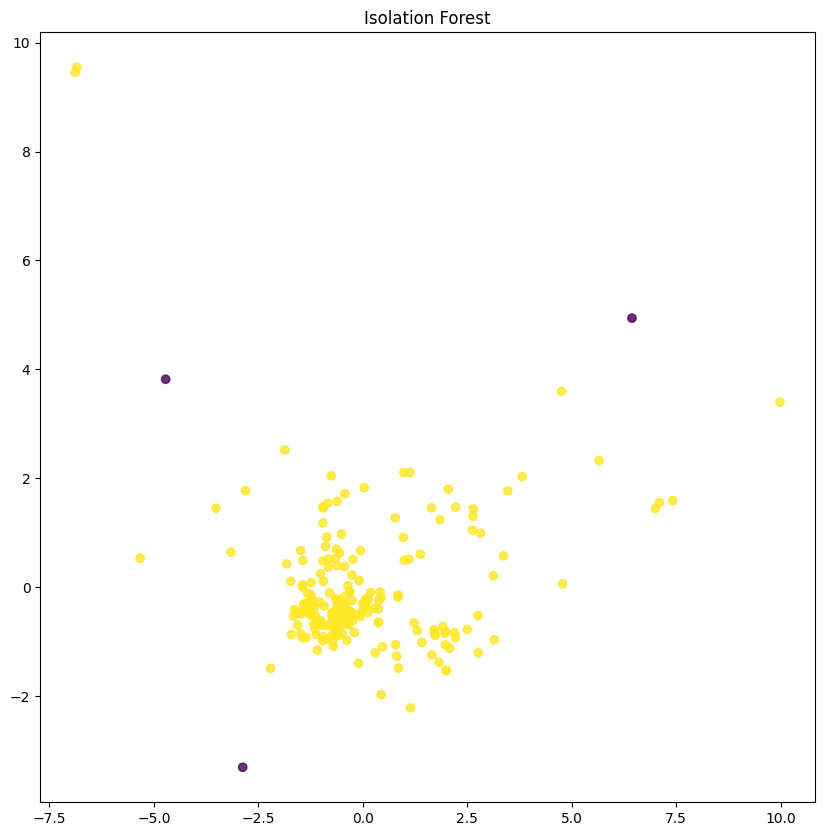

In [22]:
# Graficar la región de decisión
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=anomaly_classification, alpha=0.8)
plt.title('Isolation Forest')
plt.show()
